In [1]:
# #once per cluster
# s3helper.open_bucket('mas-dse-open',region='us-west-2')

# info_files=s3helper.ls('Weather/Info')
# Without_path=[x[13:] for x in info_files]


# !mkdir /mnt/workspace/WeatherInfo

# for i in range(len(info_files)-1):   # Last entry is the directory name
#     _from=info_files[i]
#     _to='/mnt/workspace/WeatherInfo/'+Without_path[i]
#     print('From %s to %s'%(_from,_to))
#     s3helper.s3_to_local(_from,_to)
    
# s3helper.open_bucket('dse-weather-west-2', region="us-west-2")
# s3helper.ls('')
# s3helper.s3_to_hdfs("weather.parquet", "/tmp/weather.parquet")
# s3helper.s3_to_hdfs("info/stations.parquet", "/tmp/stations.parquet")
# print(s3helper.ls_hdfs("/tmp"))

In [1]:
import os
os.getcwd()
os.chdir("/mnt/workspace/Public-DSC291/notebooks/Section2-PCA/Full_Dataset_analysis")
os.getcwd()

from Startup import *

finished standard imports
dict_items([('spark.executor.cores', '1'), ('spark.logConf', 'True'), ('spark.executor.memory', '3g'), ('spark.cores.max', '4'), ('spark.app.name', 'Weather_PCA'), ('spark.default.parallelism', '10')])
started SparkContext and SQLContext in 13.09 seconds
loaded weather.parquet in 8.10 seconds
loaded stations.parquet in 0.20 seconds
registered dataframes as tables in 0.20 seconds


# Load Data

Here we load the data for the US.  There are a few stations in Canada and Mexico included but shouldn't be a big deal

In [2]:
%%time
query="""
SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state <> '' AND weather.Measurement='PRCP'
"""

print(query)
US_weather_df=sqlContext.sql(query)
sqlContext.registerDataFrameAsTable(US_weather_df,'US_weather_df')


SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state <> '' AND weather.Measurement='PRCP'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 109 ms


In [3]:
print('US has %d rows before filter'%(US_weather_df.count()))
US_weather_df.columns
# US_weather_df.describe('latitude').show()
US_weather_df = US_weather_df.filter(US_weather_df.Year > 1960)
# US_weather_df.show(3,truncate= True)
# US_weather_df.select('Year', 'Values').show(3)
print('US has %d rows after filter'%(US_weather_df.count()))

US has 959259 rows before filter
US has 580625 rows after filter


# Do calculations

Here we calculate the anomaly per station per year.  Anom_mean refers to the anomaly over the average rainfall for a given year while Anom_sum refers to the anomaly of the total rainfal. 

In [4]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

def get_sum(row):
    row = unpackArray(row,np.float16)
    row[~np.isfinite(row)] = 0
    row = float(np.nansum(row))
    if ~np.isfinite(row): return 0
    return row

def get_mean(row):
    row = unpackArray(row,np.float16)
    row[~np.isfinite(row)] = 0
    row = float(np.nanmean(row))
    if ~np.isfinite(row): return 0
    return row

my_sum = F.UserDefinedFunction(get_sum, T.DoubleType())
my_mean = F.UserDefinedFunction(get_mean, T.DoubleType())

US_weather_df = US_weather_df.withColumn('Values_sum', my_sum('Values'))
US_weather_df = US_weather_df.withColumn('Values_mean', my_mean('Values'))

US_weather_df = US_weather_df.filter(US_weather_df.Values_sum != 0)
US_weather_df = US_weather_df.filter(US_weather_df.Values_mean != 0)

In [5]:
avg_sum = US_weather_df.groupby('Station').agg({'Values_sum': 'mean'})
avg_mean = US_weather_df.groupby('Station').agg({'Values_mean': 'mean'})
avg = avg_sum.join(avg_mean, "Station")

In [6]:
a = US_weather_df.alias('a')
b = avg.alias('b')
US_weather_df = a.join(b, "Station")

In [7]:
US_weather_df = US_weather_df.drop('Values', 'ID')

In [8]:
US_weather_df = US_weather_df.withColumn('Anom_sum', F.col('Values_sum')-F.col('avg(Values_sum)'))
US_weather_df = US_weather_df.withColumn('Anom_mean', F.col('Values_mean')-F.col('avg(Values_mean)'))

In [9]:
US_weather_df.columns

['Station',
 'elevation',
 'state',
 'latitude',
 'longitude',
 'Measurement',
 'Year',
 'Values_sum',
 'Values_mean',
 'avg(Values_sum)',
 'avg(Values_mean)',
 'Anom_sum',
 'Anom_mean']

# Calculate average anomaly per state

In [10]:
State_avg = US_weather_df.groupby('state', 'Year').agg({'Anom_mean': 'mean', 'Anom_sum': 'mean'})

In [11]:
State_avg.show()

+-----+----+-------------------+--------------------+
|state|Year|      avg(Anom_sum)|      avg(Anom_mean)|
+-----+----+-------------------+--------------------+
|   MS|2010|-1487.2689060868113|  -4.074554272991666|
|   CA|2006| -40.60206514618465|-0.11155768973669186|
|   IA|1997| -985.1584507409452|  -2.699631493937605|
|   ME|2004|-1904.0171809678732| -5.2161572812609815|
|   OH|1962|-1173.2909964440228| -3.2148284444834445|
|   OR|1976| -2441.213081056963| -6.6878651075162665|
|   SC|2006| -759.2406572438675| -2.0803878619282394|
|   WV|1981|  -666.892201074573| -1.8285084634281754|
|   WV|1990|  994.6915577613445|  2.7253577106030358|
|   MI|1993| 39.204770420656104| 0.10744579233157826|
|   PR|1970|  5636.503563112466|  15.442878218786054|
|   AZ|2013|-2766.2374741396766|  -7.578786485962923|
|   AL|1966|   225.940901181971|  0.6193557346056852|
|   FL|1968|  577.5829095482169|  1.5827792664859157|
|   NH|1961|  -1035.75239077095| -2.8368604309812424|
|   PW|1991|    861.53722943

In [12]:
pdf = State_avg.filter((F.col("state") == "CA")).toPandas()

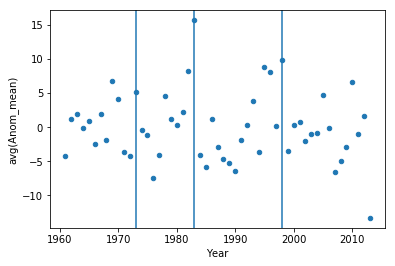

In [13]:
import matplotlib.pyplot as plt
major_elnino = [1973,  1983, 1998]
pdf.plot.scatter('Year', 'avg(Anom_mean)')
for x in major_elnino: plt.axvline(x)
plt.show()

# TO DO: Might be best to filter for stations that have values in the whole time range to avoid skewing data

# TODO: Data needs to be organized Jul-Jul to capture full rain season